In [1]:
folder = '/home/olga/data_sm/kmer-hashing/classify_coding_vs_noncoding/'

In [2]:
cd $folder

/mnt/data_sm/olga/kmer-hashing/classify_coding_vs_noncoding


In [18]:
ls -lha

total 239G
drwxrwxr-x 2 olga olga 4.0K Sep 18 05:33 ./
drwxrwxr-x 5 olga olga 4.0K Sep 14 08:39 ../
-rw-rw-r-- 1 olga olga  21M Sep 14 06:46 Homo_sapiens.GRCh38.cds.all.fa.gz
-rw-rw-r-- 1 olga olga  16M Sep 14 06:46 Homo_sapiens.GRCh38.ncrna.fa.gz
-rw-rw-r-- 1 olga olga  14M Sep 14 06:46 Homo_sapiens.GRCh38.pep.all.fa.gz
-rw-rw-r-- 1 olga olga  15G Sep 14 07:11 human_cds_k15.nodegraph
-rw-rw-r-- 1 olga olga   65 Sep 14 07:11 human_cds_k15.nodegraph.info
-rw-rw-r-- 1 olga olga  15G Sep 14 07:22 human_cds_k17.nodegraph
-rw-rw-r-- 1 olga olga   65 Sep 14 07:22 human_cds_k17.nodegraph.info
-rw-rw-r-- 1 olga olga  15G Sep 14 07:30 human_cds_k19.nodegraph
-rw-rw-r-- 1 olga olga   65 Sep 14 07:30 human_cds_k19.nodegraph.info
-rw-rw-r-- 1 olga olga  15G Sep 14 07:39 human_cds_k21.nodegraph
-rw-rw-r-- 1 olga olga   65 Sep 14 07:39 human_cds_k21.nodegraph.info
-rw-rw-r-- 1 olga olga  15G Sep 14 07:47 human_cds_k23.nodegraph
-rw-rw-r-- 1 olga olga   65 Sep 14 07:47 human_cds_k23.nodegraph.info
-r

In [19]:
import gzip
from io import StringIO
from pprint import pprint

from khmer import Nodegraph
import matplotlib.pyplot as plt
import screed
from sourmash._minhash import hash_murmur
from khmer.khmer_args import calculate_graphsize
import pandas as pd
from sourmash.logging import notify

import seaborn as sns

from sklearn import metrics
from khtools.compare_peptide import kmerize, hpize, dayhoffize

from Bio.Seq import Seq
from Bio import SeqIO

In [20]:
%%time

tablesize = 1e10

DEFAULT_K = 32
DEFAULT_N_TABLES = 4
DEFAULT_MAX_TABLESIZE = 1e6
DEFAULT_N_THREADS = 1

peptide_ksize = 7

# tablesize = calculate_graphsize(args, 'nodegraph', multiplier)

20**6

DEFAULT_SEED = 42

def make_peptide_bloom_filter(peptide_fasta, peptide_ksize, n_tables=4, seed=DEFAULT_SEED):
    """"""

    peptide_graph = Nodegraph(peptide_ksize, tablesize, n_tables=n_tables)

    for record in screed.open(peptide_fasta):
    #     print(record)
        if '*' in record['sequence']:
    #         notify("Stop codon found in seq, skipping")
            continue
        kmers = kmerize(record['sequence'], peptide_ksize)
        for kmer in kmers:

            hashed = hash_murmur(kmer)

            # .add can take the hashed integer so we can hash the peptide kmer and add it directly
            peptide_graph.add(hashed)
    return peptide_graph

peptide_graph = make_peptide_bloom_filter("Homo_sapiens.GRCh38.pep.all.fa.gz", 7)

CPU times: user 41.2 s, sys: 9 s, total: 50.2 s
Wall time: 50.3 s


In [21]:
for i, record in zip(range(5), screed.open('SRR306838_GSM752691_hsa_br_F_1_trimmed.fq.gz')):
    print(i, record)

0 {'name': 'SRR306838.1531 Ibis_Run100924_C3PO:6:1:15718:1062/1', 'sequence': 'ACCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC', 'annotations': '', 'quality': '(04147:;:9<<:7;88<<B::;<=:<:=<;>>=@>>8<;;<=;C;>;:5:;9<<::6@;E;?:C@=:9:67'}
1 {'name': 'SRR306838.1617 Ibis_Run100924_C3PO:6:1:9036:1074/1', 'sequence': 'CGTTGGTCAAGTTATTGGATCAATTGAGTATAGTAGTTCGCTTTGACTGGTGAAGTCTTAGCATG', 'annotations': '', 'quality': '44/1655:458353466544:43776271473924745866556657:54465371775397785'}
2 {'name': 'SRR306838.1672 Ibis_Run100924_C3PO:6:1:15751:1077/1', 'sequence': 'CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC', 'annotations': '', 'quality': '65<69P?HCEGKB99SSP:EMFKOS;HSSESJSGISJJMRSS=JSFOSCSSSSSSKSHSSESSSSSQSSSSSS88R'}
3 {'name': 'SRR306838.1938 Ibis_Run100924_C3PO:6:1:15775:1103/1', 'sequence': 'CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC', 'annotations': '', 'quality': '65866KD;;:=<A;O>HSBF<K:RB=<A<RS;SAE;<:

In [22]:
def three_frame_translation(seq):
    for frame in range(3):
        translation = seq[frame:].translate()
        yield translation
        
def three_frame_translation_no_stops(seq):
    return [t for t in three_frame_translation(seq) if '*' not in t]


with gzip.open('SRR306838_GSM752691_hsa_br_F_1_trimmed_subsampled.fq.gz', 'rt') as f:
    for i, record in zip(range(5), SeqIO.parse(f, 'fastq')):
        print(record.description)
        print(str(record.seq))
        print(list(three_frame_translation(record.seq)))
        print(list(three_frame_translation(record.seq[::-1])))

SRR306838.10559374 Ibis_Run100924_C3PO:6:51:17601:17119/1
CGCTTGCTTAATACTGACATCAATAATATTAGGAAAATCGCAATATAACTGTAAATCCTGTTCTGTC
[Seq('RLLNTDINNIRKIAI*L*ILFC', HasStopCodon(ExtendedIUPACProtein(), '*')), Seq('ACLILTSIILGKSQYNCKSCSV', ExtendedIUPACProtein()), Seq('LA*Y*HQ*Y*ENRNITVNPVL', HasStopCodon(ExtendedIUPACProtein(), '*'))]
[Seq('LSCPKCQYNAKRIIITTVIIRS', ExtendedIUPACProtein()), Seq('CLVLNVNITLKGL**LQS*FVR', HasStopCodon(ExtendedIUPACProtein(), '*')), Seq('VLS*MSI*R*KDYNNYSHNSF', HasStopCodon(ExtendedIUPACProtein(), '*'))]
SRR306838.6196593 Ibis_Run100924_C3PO:6:29:16733:12435/1
TCTAGAATGTGAAATAACGTACTTCATGTGTCTTCTTACCAAAAATACCAACGATAAGGGGAAAAGCCATC
[Seq('SRM*NNVLHVSSYQKYQR*GEKP', HasStopCodon(ExtendedIUPACProtein(), '*')), Seq('LECEITYFMCLLTKNTNDKGKSH', ExtendedIUPACProtein()), Seq('*NVK*RTSCVFLPKIPTIRGKAI', HasStopCodon(ExtendedIUPACProtein(), '*'))]
[Seq('LPKRGIATIKTILLCTSCNKV*D', HasStopCodon(ExtendedIUPACProtein(), '*')), Seq('YRKGE*QP*KPFFCVLHAIKCKI', HasStopCodon(ExtendedIUPA

/home/olga/miniconda3/envs/kmer-hashing/lib/python3.6/site-packages/Bio/Seq.py:2715: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning)


In [23]:
classification_lines = []


def six_frame_translation_no_stops(seq):
    forward_translations = three_frame_translation_no_stops(seq)
    reverse_translations = three_frame_translation_no_stops(seq.reverse_complement())
    return forward_translations + reverse_translations

verbose = False

with gzip.open('SRR306838_GSM752691_hsa_br_F_1_trimmed_subsampled.fq.gz', 'rt') as f:
    for i, record in zip(range(20), SeqIO.parse(f, 'fastq')):
        if verbose:
            print()
            print(record.description)
            print(str(record.seq))
        translations = six_frame_translation_no_stops(record.seq)
        
        max_fraction = 0
        for translation in translations:
            if verbose:
                print(f"\t{translation}")
            kmers = list(set(kmerize(str(translation), peptide_ksize)))
            hashes = [hash_murmur(kmer) for kmer in kmers]
            n_kmers = len(kmers)
            n_kmers_in_peptide_db = sum(1 for h in hashes if peptide_graph.get(h) > 0)
            kmers_in_peptide_db = {(k, h): peptide_graph.get(h) for k, h in zip(kmers, hashes)}
            fraction_in_peptide_db = n_kmers_in_peptide_db/n_kmers
            max_fraction = max(max_fraction, fraction_in_peptide_db)
            if verbose and fraction_in_peptide_db > 0.9:
                pprint(kmers_in_peptide_db)
            if verbose:
                print(f'n_kmers_in_peptide_db/n_kmers: {n_kmers_in_peptide_db}/{n_kmers} = {fraction_in_peptide_db}')
        classification_lines.append([record.description, max_fraction])

/home/olga/miniconda3/envs/kmer-hashing/lib/python3.6/site-packages/Bio/Seq.py:2715: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning)


In [24]:
manual_classification_df = pd.DataFrame(classification_lines, columns=['read_id', 'max_peptide_coding_kmers'])
manual_classification_df = manual_classification_df.set_index("read_id")
print(manual_classification_df.shape)
manual_classification_df.head()

(20, 1)


,max_peptide_coding_kmers
read_id,
SRR306838.10559374 Ibis_Run100924_C3PO:6:51:17601:17119/1,1.000000
SRR306838.6196593 Ibis_Run100924_C3PO:6:29:16733:12435/1,0.000000
SRR306838.20767303 Ibis_Run100924_C3PO:6:104:6864:5062/1,0.187500
SRR306838.12582274 Ibis_Run100924_C3PO:6:62:11779:17975/1,0.066667
SRR306838.13334230 Ibis_Run100924_C3PO:6:66:16579:20350/1,0.000000


In [25]:
s = '''sequence_id	sequence	compared_to	jaccard	ksize	is_coding	Notes
SRR306838.10559374 Ibis_Run100924_C3PO:6:51:17601:17119/1	CGCTTGCTTAATACTGACATCAATAATATTAGGAAAATCGCAATATAACTGTAAATCCTGTTCTGTC	coding	0.03773584906	15	TRUE	
SRR306838.10559374 Ibis_Run100924_C3PO:6:51:17601:17119/1	CGCTTGCTTAATACTGACATCAATAATATTAGGAAAATCGCAATATAACTGTAAATCCTGTTCTGTC	non_coding	0	15	TRUE	
SRR306838.6196593 Ibis_Run100924_C3PO:6:29:16733:12435/1	TCTAGAATGTGAAATAACGTACTTCATGTGTCTTCTTACCAAAAATACCAACGATAAGGGGAAAAGCCATC	coding	0.0350877193	15	FALSE	
SRR306838.6196593 Ibis_Run100924_C3PO:6:29:16733:12435/1	TCTAGAATGTGAAATAACGTACTTCATGTGTCTTCTTACCAAAAATACCAACGATAAGGGGAAAAGCCATC	non_coding	0.01754385965	15	FALSE	
SRR306838.20767303 Ibis_Run100924_C3PO:6:104:6864:5062/1	CAATCATCATCACTTTCTAATTCCAGAATATTTTCATCACCCCAAAAAGAAATCCTAAATCCATTAGC	coding	0.09259259259	15	FALSE	
SRR306838.20767303 Ibis_Run100924_C3PO:6:104:6864:5062/1	CAATCATCATCACTTTCTAATTCCAGAATATTTTCATCACCCCAAAAAGAAATCCTAAATCCATTAGC	non_coding	0.4074074074	15	FALSE	
SRR306838.12582274 Ibis_Run100924_C3PO:6:62:11779:17975/1	CAAAAGTGAAGACCTCCCTGGGGTCTTCAAAGACAGCCTTTGCTCTCCATGTAGCCAATGGTGCTCT	coding	0.03773584906	15	FALSE	
SRR306838.12582274 Ibis_Run100924_C3PO:6:62:11779:17975/1	CAAAAGTGAAGACCTCCCTGGGGTCTTCAAAGACAGCCTTTGCTCTCCATGTAGCCAATGGTGCTCT	non_coding	0.05660377358	15	FALSE	
SRR306838.13334230 Ibis_Run100924_C3PO:6:66:16579:20350/1	GTAACCCTTAATTCCTCAGAAAAAATAGACAACATAGTGGAGTGGGATGGAGGAAC	coding	0.04761904762	15	FALSE	
SRR306838.13334230 Ibis_Run100924_C3PO:6:66:16579:20350/1	GTAACCCTTAATTCCTCAGAAAAAATAGACAACATAGTGGAGTGGGATGGAGGAAC	non_coding	0.1428571429	15	FALSE	
SRR306838.2740879 Ibis_Run100924_C3PO:6:13:11155:5248/1	CTGTGATTATTTTTTTTCCTAGCATTTGTTCTTTCAGAAAAGGACTGAACTCTAAATTCTGGACTTGAAGACTG	coding	0.06666666667	15	TRUE	Second hit is in LINE element
SRR306838.2740879 Ibis_Run100924_C3PO:6:13:11155:5248/1	CTGTGATTATTTTTTTTCCTAGCATTTGTTCTTTCAGAAAAGGACTGAACTCTAAATTCTGGACTTGAAGACTG	non_coding	0.08333333333	15	TRUE	Second hit is in LINE element
SRR306838.6813354 Ibis_Run100924_C3PO:6:32:10591:13073/1	GTTTGATTCTTGACAATTTCTTCTGGAACAAGTCTTTCATATACATTAGACTGGTATCATTGAGTTCTGAGC	coding	0.03448275862	15	FALSE	Lots of imperfect matches
SRR306838.6813354 Ibis_Run100924_C3PO:6:32:10591:13073/1	GTTTGATTCTTGACAATTTCTTCTGGAACAAGTCTTTCATATACATTAGACTGGTATCATTGAGTTCTGAGC	non_coding	0.08620689655	15	FALSE	Lots of imperfect matches
SRR306838.23113368 Ibis_Run100924_C3PO:6:114:13840:18459/1	CACAAGGCTAACATACACAATCTGTAACACGAGATGGATAGCACACACATATGACACAATTTC	coding	0	15	FALSE	
SRR306838.23113368 Ibis_Run100924_C3PO:6:114:13840:18459/1	CACAAGGCTAACATACACAATCTGTAACACGAGATGGATAGCACACACATATGACACAATTTC	non_coding	0	15	FALSE	
SRR306838.10872941 Ibis_Run100924_C3PO:6:53:6164:10522/1	CTGTAGTGTGGTCCATTCCCAGACAGCAACATGCAAGAATAAGTTTACAATACACTCAGCCCTTCTG	coding	0.01886792453	15	FALSE	
SRR306838.10872941 Ibis_Run100924_C3PO:6:53:6164:10522/1	CTGTAGTGTGGTCCATTCCCAGACAGCAACATGCAAGAATAAGTTTACAATACACTCAGCCCTTCTG	non_coding	0.01886792453	15	FALSE	
SRR306838.6192120 Ibis_Run100924_C3PO:6:29:5833:11991/1	TAGGAAAATAGTAATATTTGCAACTTATGAATGATAAGTCAGAAAAGTTACATGGAATGTTAAATTTT	coding	0.1296296296	15	FALSE	
SRR306838.6192120 Ibis_Run100924_C3PO:6:29:5833:11991/1	TAGGAAAATAGTAATATTTGCAACTTATGAATGATAAGTCAGAAAAGTTACATGGAATGTTAAATTTT	non_coding	0.05555555556	15	FALSE	
SRR306838.21295280 Ibis_Run100924_C3PO:6:106:2590:13965/1	CTGATAGACTGAAACTGGTTTTGTTATTCTTAACGTTCTCCAGTCTGCACTCTGCTGTGCTGTCTGTGCTC	coding	0.1929824561	15	FALSE	
SRR306838.21295280 Ibis_Run100924_C3PO:6:106:2590:13965/1	CTGATAGACTGAAACTGGTTTTGTTATTCTTAACGTTCTCCAGTCTGCACTCTGCTGTGCTGTCTGTGCTC	non_coding	0.0701754386	15	FALSE	
SRR306838.21201208 Ibis_Run100924_C3PO:6:106:2763:5109/1	TTAAGTTCTAGTCTGTGAGCACTTGTAGTTCAATAATCGTCATCTTCATCAGAGTCCATTACTTTTCTTCTGTTG	coding	0.1147540984	15	FALSE	stop codon
SRR306838.21201208 Ibis_Run100924_C3PO:6:106:2763:5109/1	TTAAGTTCTAGTCTGTGAGCACTTGTAGTTCAATAATCGTCATCTTCATCAGAGTCCATTACTTTTCTTCTGTTG	non_coding	0.06557377049	15	FALSE	stop codon
SRR306838.18327923 Ibis_Run100924_C3PO:6:92:9077:13885/1	AAATAAGGTAACATTTAACAATAATCTGATACACATAAATAGAGAAAGAGCAATTGATAAAGTAAATG	coding	0.01851851852	15	FALSE	
SRR306838.18327923 Ibis_Run100924_C3PO:6:92:9077:13885/1	AAATAAGGTAACATTTAACAATAATCTGATACACATAAATAGAGAAAGAGCAATTGATAAAGTAAATG	non_coding	0.2222222222	15	FALSE	
SRR306838.4880582 Ibis_Run100924_C3PO:6:23:17413:5436/1	CTTGGATCCACCATACTCAAGAGTTATTACACAAAGGGAAACAGAAAATAACCAAATGACATCAGAA	coding	1	15	TRUE	
SRR306838.4880582 Ibis_Run100924_C3PO:6:23:17413:5436/1	CTTGGATCCACCATACTCAAGAGTTATTACACAAAGGGAAACAGAAAATAACCAAATGACATCAGAA	non_coding	0.1698113208	15	TRUE	
SRR306838.21417895 Ibis_Run100924_C3PO:6:107:8793:5012/1	CCAACACATCCAATTTGTATTTTCTTAAATATGTGTTTCTTAGGTATCTAAGGATACATGAGCGAGCCC	coding	0	15	FALSE	
SRR306838.21417895 Ibis_Run100924_C3PO:6:107:8793:5012/1	CCAACACATCCAATTTGTATTTTCTTAAATATGTGTTTCTTAGGTATCTAAGGATACATGAGCGAGCCC	non_coding	0.01818181818	15	FALSE	
SRR306838.17165743 Ibis_Run100924_C3PO:6:86:18789:18450/1	ATCTCTTGTAATAATTCAACATATTCCCTGGCTATTAACTAATTTCCAAGCCTGAACTGTCA	coding	0.04166666667	15	FALSE	
SRR306838.17165743 Ibis_Run100924_C3PO:6:86:18789:18450/1	ATCTCTTGTAATAATTCAACATATTCCCTGGCTATTAACTAATTTCCAAGCCTGAACTGTCA	non_coding	0	15	FALSE	
SRR306838.21229494 Ibis_Run100924_C3PO:6:106:6163:7753/1	TGAGGCAAACAGCAAGAGTAAGCAGTGTTACTTGCAGGTACTTTGGTTAATGTTGATTTAAATTTTCATG	coding	0	15	FALSE	Perfect match to another location with a DNA element
SRR306838.21229494 Ibis_Run100924_C3PO:6:106:6163:7753/1	TGAGGCAAACAGCAAGAGTAAGCAGTGTTACTTGCAGGTACTTTGGTTAATGTTGATTTAAATTTTCATG	non_coding	0.03571428571	15	FALSE	
SRR306838.21218773 Ibis_Run100924_C3PO:6:106:16921:6743/1	CAATGCCGTGCCAGTGGAGACTGTTCTCGTATGCC	coding	0.09523809524	15	TRUE	Deinitely coding
SRR306838.21218773 Ibis_Run100924_C3PO:6:106:16921:6743/1	CAATGCCGTGCCAGTGGAGACTGTTCTCGTATGCC	non_coding	0	15	TRUE	
SRR306838.20124664 Ibis_Run100924_C3PO:6:101:4701:5309/1	CCTATACCTTCTGCATAATGAATTAACTAGAAATAACTTTGCAAGGAGAGCCAAAGCTAAGACCCCCGAAAC	coding	0.01724137931	15	FALSE	Definitely noncoding
SRR306838.20124664 Ibis_Run100924_C3PO:6:101:4701:5309/1	CCTATACCTTCTGCATAATGAATTAACTAGAAATAACTTTGCAAGGAGAGCCAAAGCTAAGACCCCCGAAAC	non_coding	1	15	FALSE	Definitely noncoding
SRR306838.16841308 Ibis_Run100924_C3PO:6:85:6205:5805/1	CAGGAATGAGGCCCCGACTAAAATTCGCTGCAAAAGCCCAAAATCTAGTTAGCATAAATTCCTCAGACATG	coding	0	15	FALSE	
SRR306838.16841308 Ibis_Run100924_C3PO:6:85:6205:5805/1	CAGGAATGAGGCCCCGACTAAAATTCGCTGCAAAAGCCCAAAATCTAGTTAGCATAAATTCCTCAGACATG	non_coding	0.0701754386	15	FALSE	'''
blat_results = pd.read_csv(StringIO(s), sep='\t', index_col=0)
print(blat_results.shape)
blat_results.head()

(40, 6)


,sequence,compared_to,jaccard,ksize,is_coding,Notes
sequence_id,,,,,,
SRR306838.10559374 Ibis_Run100924_C3PO:6:51:17601:17119/1,CGCTTGCTTAATACTGACATCAATAATATTAGGAAAATCGCAATAT...,coding,0.037736,15,True,NaN
SRR306838.10559374 Ibis_Run100924_C3PO:6:51:17601:17119/1,CGCTTGCTTAATACTGACATCAATAATATTAGGAAAATCGCAATAT...,non_coding,0.000000,15,True,NaN
SRR306838.6196593 Ibis_Run100924_C3PO:6:29:16733:12435/1,TCTAGAATGTGAAATAACGTACTTCATGTGTCTTCTTACCAAAAAT...,coding,0.035088,15,False,NaN
SRR306838.6196593 Ibis_Run100924_C3PO:6:29:16733:12435/1,TCTAGAATGTGAAATAACGTACTTCATGTGTCTTCTTACCAAAAAT...,non_coding,0.017544,15,False,NaN
SRR306838.20767303 Ibis_Run100924_C3PO:6:104:6864:5062/1,CAATCATCATCACTTTCTAATTCCAGAATATTTTCATCACCCCAAA...,coding,0.092593,15,False,NaN


In [26]:
true_coding = blat_results['is_coding']
true_coding = true_coding.loc[~true_coding.index.duplicated()]
true_coding.head()

sequence_id
SRR306838.10559374 Ibis_Run100924_C3PO:6:51:17601:17119/1     True
SRR306838.6196593 Ibis_Run100924_C3PO:6:29:16733:12435/1     False
SRR306838.20767303 Ibis_Run100924_C3PO:6:104:6864:5062/1     False
SRR306838.12582274 Ibis_Run100924_C3PO:6:62:11779:17975/1    False
SRR306838.13334230 Ibis_Run100924_C3PO:6:66:16579:20350/1    False
Name: is_coding, dtype: bool

In [27]:
manual_classification_df['is_coding'] = true_coding
print(manual_classification_df.shape)
manual_classification_df

(20, 2)


,max_peptide_coding_kmers,is_coding
read_id,,
SRR306838.10559374 Ibis_Run100924_C3PO:6:51:17601:17119/1,1.000000,True
SRR306838.6196593 Ibis_Run100924_C3PO:6:29:16733:12435/1,0.000000,False
SRR306838.20767303 Ibis_Run100924_C3PO:6:104:6864:5062/1,0.187500,False
SRR306838.12582274 Ibis_Run100924_C3PO:6:62:11779:17975/1,0.066667,False
SRR306838.13334230 Ibis_Run100924_C3PO:6:66:16579:20350/1,0.000000,False
SRR306838.2740879 Ibis_Run100924_C3PO:6:13:11155:5248/1,1.000000,True
SRR306838.6813354 Ibis_Run100924_C3PO:6:32:10591:13073/1,0.000000,False
SRR306838.23113368 Ibis_Run100924_C3PO:6:114:13840:18459/1,0.000000,False
SRR306838.10872941 Ibis_Run100924_C3PO:6:53:6164:10522/1,0.000000,False


[Text(0, 0.5, 'True Positive Rate'), Text(0.5, 0, 'False Positive Rate')]

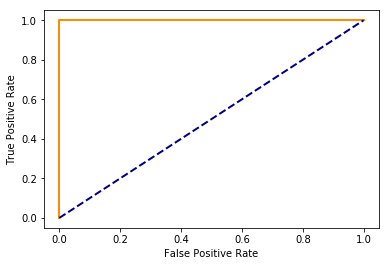

In [28]:
fpr, tpr, thresholds = metrics.roc_curve(manual_classification_df['is_coding'], manual_classification_df['max_peptide_coding_kmers'])

fig, ax = plt.subplots()
lw = 2
ax.plot(fpr, tpr, lw=2, color='darkorange')
ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate')

In [29]:
kmers_in_peptide_db

{('ANFSRGL', 7431286104868480707): 0,
 ('SEEFMLT', 16675615962310747344): 0,
 ('WAFAANF', 10169538930719698058): 0,
 ('MLTRFWA', 5582379834364749297): 0,
 ('AFAANFS', 6180876687570675151): 0,
 ('EEFMLTR', 7965125036651070805): 0,
 ('RFWAFAA', 13096937205154710457): 0,
 ('LTRFWAF', 10289205403418582936): 0,
 ('MSEEFML', 9186023756098901264): 0,
 ('EFMLTRF', 6952115361773831145): 0,
 ('FAANFSR', 14753373647675143200): 0,
 ('NFSRGLI', 1716268342264010659): 0,
 ('FMLTRFW', 7895814335313085407): 0,
 ('TRFWAFA', 10364635084274506663): 0,
 ('AANFSRG', 15900282725054178434): 0,
 ('FSRGLIP', 11768402438034235620): 0,
 ('FWAFAAN', 439507165265523591): 0}

In [30]:
record.seq.reverse_complement()

Seq('CATGTCTGAGGAATTTATGCTAACTAGATTTTGGGCTTTTGCAGCGAATTTTAG...CTG', SingleLetterAlphabet())


> hi! I’m traveling so may take me a bit. suggest -> sourmash or general channels since luiz and others may have thoughts
> I have done this a lot so I’ll look at it tho!
> p.s. try ‘hashbits’ rather than nodegraph.add, if that makes sense - will track down my advice in more detail shortly :slightly_smiling_face:
> but never mind that, let someone look first

## Try on the whole dataset

In [32]:
classification_lines = []


scoring_lines = []

def six_frame_translation_no_stops(seq):
    forward_translations = three_frame_translation_no_stops(seq)
    reverse_translations = three_frame_translation_no_stops(seq.reverse_complement())
    return forward_translations + reverse_translations

verbose = False

jaccard_threshold = 0.9

with gzip.open('SRR306838_GSM752691_hsa_br_F_1_trimmed.fq.gz', 'rt') as f:
    for record in SeqIO.parse(f, 'fastq'):
        if verbose:
            print()
            print(record.description)
            print(str(record.seq))
        translations = six_frame_translation_no_stops(record.seq)

        max_fraction = 0
        for translation in translations:
            if len(translation) < peptide_ksize:
                continue
            if verbose:
                print(f"\t{translation}")
            kmers = list(set(kmerize(str(translation), peptide_ksize)))
            hashes = [hash_murmur(kmer) for kmer in kmers]
            n_kmers = len(kmers)
            n_kmers_in_peptide_db = sum(1 for h in hashes if peptide_graph.get(h) > 0)
            if n_kmers < (len(translation) - peptide_ksize + 1)/2:
                if verbose:
                    print(f'Low complexity sequence!!! n_kmers < (len(read.seq) - ksize + 1)/2  --> {n_kmers} < {(len(record.seq) - ksize + 1)/2}')
                    print(record.description)
                    print(record.seq)
                classification_lines.append([record.description, 'low complexity'])
                continue

            kmers_in_peptide_db = {(k, h): peptide_graph.get(h) for k, h in zip(kmers, hashes)}
            fraction_in_peptide_db = n_kmers_in_peptide_db/n_kmers
            max_fraction = max(max_fraction, fraction_in_peptide_db)
            if fraction_in_peptide_db > jaccard_threshold:
                classification_lines.append([record.description, 'coding'])
            else:
                classification_lines.append([record.description, 'non-coding'])
            if verbose:
                pprint(kmers_in_peptide_db)
                print(f'n_kmers_in_peptide_db/n_kmers: {n_kmers_in_peptide_db}/{n_kmers} = {fraction_in_peptide_db}')
        scoring_lines.append([record.description, max_fraction])

    classification_df = pd.DataFrame(classification_lines, columns=['read_id', 'classification'])
    print(classification_df.shape)
    classification_df.head()

/home/olga/miniconda3/envs/kmer-hashing/lib/python3.6/site-packages/Bio/Seq.py:2715: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning)


(1668180, 2)


In [33]:


def six_frame_translation_no_stops(seq):
    forward_translations = three_frame_translation_no_stops(seq)
    reverse_translations = three_frame_translation_no_stops(seq.reverse_complement())
    return forward_translations + reverse_translations

verbose = False

def classify_protein_coding_reads(reads, peptide_graph, peptide_ksize, jaccard_minimum=0.9, first_n=None, verbose=False):
    
    classification_lines = []

    scoring_lines = []

    with gzip.open(reads, 'rt') as f:
        for record in SeqIO.parse(f, 'fastq'):
            if first_n is not None and i > first_n:
                break

            if verbose:
                print()
                print(record.description)
                print(str(record.seq))
            translations = six_frame_translation_no_stops(record.seq)

            max_fraction = 0
            for translation in translations:
                if len(translation) < peptide_ksize:
                    continue
                if verbose:
                    print(f"\t{translation}")
                kmers = list(set(kmerize(str(translation), peptide_ksize)))
                hashes = [hash_murmur(kmer) for kmer in kmers]
                n_kmers = len(kmers)
                n_kmers_in_peptide_db = sum(1 for h in hashes if peptide_graph.get(h) > 0)
                if n_kmers < (len(translation) - peptide_ksize + 1)/2:
                    if verbose:
                        print(f'Low complexity sequence!!! n_kmers < (len(read.seq) - ksize + 1)/2  --> {n_kmers} < {(len(record.seq) - ksize + 1)/2}')
                        print(record.description)
                        print(record.seq)
                    classification_lines.append([record.description, 'low complexity'])
                    continue

                kmers_in_peptide_db = {(k, h): peptide_graph.get(h) for k, h in zip(kmers, hashes)}
                fraction_in_peptide_db = n_kmers_in_peptide_db/n_kmers
                max_fraction = max(max_fraction, fraction_in_peptide_db)
                if fraction_in_peptide_db > jaccard_minimum:
                    classification_lines.append([record.description, 'coding'])
                else:
                    classification_lines.append([record.description, 'non-coding'])
                if verbose:
                    pprint(kmers_in_peptide_db)
                    print(f'n_kmers_in_peptide_db/n_kmers: {n_kmers_in_peptide_db}/{n_kmers} = {fraction_in_peptide_db}')
                scoring_lines.append([record.description, max_fraction])

        classification_df = pd.DataFrame(classification_lines, columns=['read_id', 'classification'])
        score_df = pd.DataFrame(scoring_lines, columns=['read_id', 'coding_score'])
        
        return classification_df, score_df
    
    


In [34]:
class_df, score_df = classify_protein_coding_reads('SRR306838_GSM752691_hsa_br_F_1_trimmed.fq.gz', 
                                                   peptide_graph, peptide_ksize, verbose=False)

/home/olga/miniconda3/envs/kmer-hashing/lib/python3.6/site-packages/Bio/Seq.py:2715: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning)


In [35]:
folder = '/home/olga/data_sm/kmer-hashing/brawand2011/human/'
! ls -lha $folder

coding_read_ids = pd.read_csv(f"{folder}/SRR306838_GSM752691_hsa_br_F_1Aligned.sortedByCoord.out.bam.unspliced.out_CDS_without_stop_codon_or_utr.read_ids.txt", 
                                   header=None, squeeze=True)
print(coding_read_ids.shape)
coding_read_ids.head()

true_coding_read_ids = set(coding_read_ids.values)
len(true_coding_read_ids)

unspliced_read_ids_series = pd.read_csv(f"{folder}/SRR306838_GSM752691_hsa_br_F_1Aligned.sortedByCoord.out.bam.unspliced.read_ids.txt", 
                                   header=None, squeeze=True)
print(unspliced_read_ids_series.shape)
unspliced_read_ids_series.head()

unspliced_reads = set(unspliced_read_ids_series.values)

total 358M
drwxrwxr-x 2 olga olga 4.0K Sep 18 10:15 .
drwxrwxr-x 3 olga olga 4.0K Sep 10 15:07 ..
-rw-rw-r-- 1 olga olga  52M Sep 18 10:05 SRR306838_GSM752691_hsa_br_F_1Aligned.sortedByCoord.out.bam.unspliced.bam
-rw-rw-r-- 1 olga olga 2.9M Sep 18 10:12 SRR306838_GSM752691_hsa_br_F_1Aligned.sortedByCoord.out.bam.unspliced.bam.bai
-rw-rw-r-- 1 olga olga 9.3M Sep 18 10:12 SRR306838_GSM752691_hsa_br_F_1Aligned.sortedByCoord.out.bam.unspliced.out_CDS_without_stop_codon_or_utr.bam
-rw-rw-r-- 1 olga olga 1.9M Sep 18 10:12 SRR306838_GSM752691_hsa_br_F_1Aligned.sortedByCoord.out.bam.unspliced.out_CDS_without_stop_codon_or_utr.bam.bai
-rw-rw-r-- 1 olga olga 2.8M Sep 18 10:14 SRR306838_GSM752691_hsa_br_F_1Aligned.sortedByCoord.out.bam.unspliced.out_CDS_without_stop_codon_or_utr.read_ids.txt
-rw-rw-r-- 1 olga olga  15M Sep 18 10:15 SRR306838_GSM752691_hsa_br_F_1Aligned.sortedByCoord.out.bam.unspliced.read_ids.txt
-rw-rw-r-- 1 olga olga  15M Sep 10 15:55 SRR306838_GSM752691_hsa_br_F_1Aligned.sorte

In [36]:
def subset_to_spliced_and_add_coding_classification(full_classification, unspliced_reads, true_coding_reads, read_id_col='read_id'):
    full_classification['short_sequence_id'] = full_classification[read_id_col].str.split().str[0]

    full_classification_unspliced = full_classification.query("short_sequence_id in @unspliced_reads")

    full_classification_unspliced['is_coding'] = full_classification_unspliced.short_sequence_id.isin(true_coding_reads)
    return full_classification_unspliced

In [58]:
pd.options.display.max_colwidth = 500

In [59]:
score_df_unspliced = subset_to_spliced_and_add_coding_classification(score_df, unspliced_reads, true_coding_read_ids)
print(score_df_unspliced.shape)
score_df_unspliced.head()

(1363508, 4)


/home/olga/miniconda3/envs/kmer-hashing/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,read_id,coding_score,short_sequence_id,is_coding
10,SRR306838.3707 Ibis_Run100924_C3PO:6:1:5241:1269/1,0.0,SRR306838.3707,False
11,SRR306838.3707 Ibis_Run100924_C3PO:6:1:5241:1269/1,0.0,SRR306838.3707,False
12,SRR306838.3707 Ibis_Run100924_C3PO:6:1:5241:1269/1,1.0,SRR306838.3707,False
13,SRR306838.4251 Ibis_Run100924_C3PO:6:1:5141:1314/1,0.0,SRR306838.4251,False
14,SRR306838.4936 Ibis_Run100924_C3PO:6:1:5473:1375/1,0.0,SRR306838.4936,False


In [38]:
classification_df_unspliced = subset_to_spliced_and_add_coding_classification(classification_df, unspliced_reads, true_coding_read_ids)
print(classification_df_unspliced.shape)
classification_df_unspliced.head()

(1366083, 4)


/home/olga/miniconda3/envs/kmer-hashing/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,read_id,classification,short_sequence_id,is_coding
6,SRR306838.1672 Ibis_Run100924_C3PO:6:1:15751:1...,low complexity,SRR306838.1672,False
7,SRR306838.1672 Ibis_Run100924_C3PO:6:1:15751:1...,low complexity,SRR306838.1672,False
8,SRR306838.1672 Ibis_Run100924_C3PO:6:1:15751:1...,low complexity,SRR306838.1672,False
9,SRR306838.1672 Ibis_Run100924_C3PO:6:1:15751:1...,low complexity,SRR306838.1672,False
10,SRR306838.1672 Ibis_Run100924_C3PO:6:1:15751:1...,low complexity,SRR306838.1672,False


In [39]:
metrics.roc_auc_score(score_df_unspliced['is_coding'], score_df_unspliced['coding_score'])

0.7191046283881481

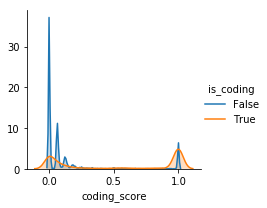

In [56]:
g = sns.FacetGrid(score_df_unspliced, hue='is_coding')
g.map(sns.kdeplot, 'coding_score', shade=True)
g.add_legend()

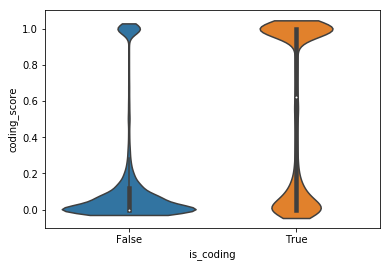

In [52]:
sns.violinplot(x='is_coding', y='coding_score', data=score_df_unspliced, bw=0.1, cut=True)

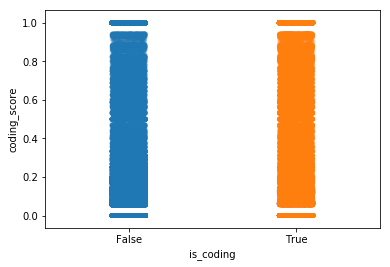

In [57]:
sns.stripplot(x='is_coding', y='coding_score', data=score_df_unspliced, alpha=0.1)

In [41]:
predicted = score_df_unspliced['coding_score'] > 0.9
target = score_df_unspliced['is_coding']

## which reads disagree?

### Truly coding reads that were skipped

In [60]:
score_df_unspliced.query('is_coding == True & coding_score < 0.5').sample(10, random_state=0)

,read_id,coding_score,short_sequence_id,is_coding
925560,SRR306838.13870260 Ibis_Run100924_C3PO:6:69:16561:18172/1,0.000000,SRR306838.13870260,True
1277047,SRR306838.18658186 Ibis_Run100924_C3PO:6:94:3144:5690/1,0.000000,SRR306838.18658186,True
1194418,SRR306838.17027611 Ibis_Run100924_C3PO:6:86:10019:4369/1,0.062500,SRR306838.17027611,True
1500092,SRR306838.22088112 Ibis_Run100924_C3PO:6:110:7208:6075/1,0.200000,SRR306838.22088112,True
227050,SRR306838.5412242 Ibis_Run100924_C3PO:6:25:13501:16618/1,0.000000,SRR306838.5412242,True
490959,SRR306838.10636481 Ibis_Run100924_C3PO:6:52:6797:5102/1,0.000000,SRR306838.10636481,True
1460357,SRR306838.21644393 Ibis_Run100924_C3PO:6:108:5524:5694/1,0.142857,SRR306838.21644393,True
659240,SRR306838.12271422 Ibis_Run100924_C3PO:6:61:4913:3117/1,0.000000,SRR306838.12271422,True
1135892,SRR306838.16162975 Ibis_Run100924_C3PO:6:81:17299:17642/1,0.000000,SRR306838.16162975,True
807475,SRR306838.13118204 Ibis_Run100924_C3PO:6:65:11711:16778/1,0.000000,SRR306838.13118204,True


In [ ]:
score_df_unspliced.query('is_coding == True & coding_score < 0.5').sample(10, random_state=0)

In [63]:
bam = 'SRR306838_GSM752691_hsa_br_F_1Aligned.sortedByCoord.out_CDS_without_stop_codon_or_utr.bam'
! samtools view $folder/$bam | grep 'SRR306838.13870260'

SRR306838.13870260	0	chr2	37646201	255	72M	*	0	0	ATTAAATGTCACTGGTGACAATAAGGGCAACATGAGAGCTTGGGATCCTCCAATGGTCGGGAGGGAGATGGC	*313448447447831756776527665556574364937:665557654545985265564:753766755	NH:i:1	HI:i:1	AS:i:70	nM:i:0	RG:Z:SRR306838_GSM752691_hsa_br_F_1


In [65]:
seq = Seq('ATTAAATGTCACTGGTGACAATAAGGGCAACATGAGAGCTTGGGATCCTCCAATGGTCGGGAGGGAGATGGC')

translations = six_frame_translation_no_stops(seq)

/home/olga/miniconda3/envs/kmer-hashing/lib/python3.6/site-packages/Bio/Seq.py:2715: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning)


In [66]:
for translation in translations:
    kmers = list(set(kmerize(str(translation), peptide_ksize)))
    hashes = [hash_murmur(kmer) for kmer in kmers]
    n_kmers = len(kmers)
    n_kmers_in_peptide_db = sum(1 for h in hashes if
                                peptide_graph.get(h) > 0)
    print(n_kmers_in_peptide_db)

0
18


In [ ]:
peptide_graph.get()

### Noncoding reads that were thought to be coding

In [61]:
score_df_unspliced.query('is_coding == False & coding_score > 0.5').sample(10, random_state=0)

,read_id,coding_score,short_sequence_id,is_coding
1028559,SRR306838.14889198 Ibis_Run100924_C3PO:6:75:17829:5841/1,1.000000,SRR306838.14889198,False
353969,SRR306838.8204931 Ibis_Run100924_C3PO:6:39:4925:12194/1,1.000000,SRR306838.8204931,False
603097,SRR306838.11788467 Ibis_Run100924_C3PO:6:58:5578:9971/1,1.000000,SRR306838.11788467,False
1182282,SRR306838.16841539 Ibis_Run100924_C3PO:6:85:6965:5823/1,0.764706,SRR306838.16841539,False
1472401,SRR306838.21829333 Ibis_Run100924_C3PO:6:109:6086:2456/1,1.000000,SRR306838.21829333,False
423666,SRR306838.9560645 Ibis_Run100924_C3PO:6:46:12256:11594/1,0.588235,SRR306838.9560645,False
1423432,SRR306838.21218642 Ibis_Run100924_C3PO:6:106:17561:6732/1,0.705882,SRR306838.21218642,False
1327996,SRR306838.19605837 Ibis_Run100924_C3PO:6:98:6106:16627/1,1.000000,SRR306838.19605837,False
1210562,SRR306838.17227687 Ibis_Run100924_C3PO:6:87:6039:4341/1,1.000000,SRR306838.17227687,False
1021073,SRR306838.14806284 Ibis_Run100924_C3PO:6:74:5280:17432/1,1.000000,SRR306838.14806284,False


In [45]:
score_df_unspliced.head()

,read_id,coding_score,short_sequence_id,is_coding
10,SRR306838.3707 Ibis_Run100924_C3PO:6:1:5241:12...,0.0,SRR306838.3707,False
11,SRR306838.3707 Ibis_Run100924_C3PO:6:1:5241:12...,0.0,SRR306838.3707,False
12,SRR306838.3707 Ibis_Run100924_C3PO:6:1:5241:12...,1.0,SRR306838.3707,False
13,SRR306838.4251 Ibis_Run100924_C3PO:6:1:5141:13...,0.0,SRR306838.4251,False
14,SRR306838.4936 Ibis_Run100924_C3PO:6:1:5473:13...,0.0,SRR306838.4936,False


In [42]:
import numpy as np

In [43]:
print(np.mean(predicted == target))
print(metrics.classification_report(target, predicted, target_names=['noncoding', 'coding']))
print(metrics.confusion_matrix(target, predicted))

0.7848725493359775
              precision    recall  f1-score   support

   noncoding       0.81      0.91      0.86    984850
      coding       0.66      0.46      0.54    378658

   micro avg       0.78      0.78      0.78   1363508
   macro avg       0.74      0.69      0.70   1363508
weighted avg       0.77      0.78      0.77   1363508

[[895062  89788]
 [203540 175118]]


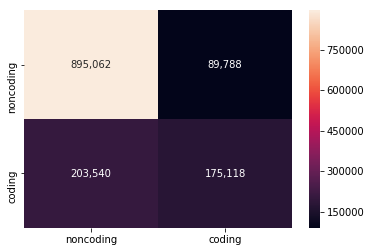

In [44]:
target_names=['noncoding', 'coding']

confusion = pd.DataFrame(metrics.confusion_matrix(target, predicted), index=target_names, columns=target_names)

sns.heatmap(confusion, annot=True, fmt=',d')